# Generative Adversarial Networks
[Introduced in 2014 by Ian Goodfellow](https://arxiv.org/pdf/1406.2661.pdf), GANs are an alternative to VAEs for learning latent spaces. They enable the generation of fairly realistic synthetic images by forcing the generated images to be statistically almost indistinguishable from real ones.

### An Intuitive way to understand
Imagine a **forger** trying to create fake currency note. At first, the forger is pretty bad at the task. He is caught by cops and cops tell him where he missed in forging. Forger tries again and again. As time goes on, the forger becomes increasingly competent at imitating the currency, and cops become increasingly expert at spotting fakes. In the end we have some amazing fakes.

That's what a GAN is, *a forger and an expert network*.



- **Generator Network** :- Takes as input a random vector(a random point in latent space), and decodes it into a synthetic image.
- **Discriminator network(or adversary)** :- Takes as input an image and predicts whether the image came from training set or was created by genrator network.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/gans_gfg.jpg" height="400">

> *GANs are difficult to train because optimisation minimum is not fixed, every step taken down following gradient descent changes the landscape. It's a dynamic system where optimization process is seeking equilibrium instead of minimum.*

### Basic imports and declarations
> - We will train the GAN on imahes from CIFAR10, a dataset of 50k 32*32 RGB images belonging to 10 classes. We will use one class only.
- We will make DCGAN(deep conv GAN), in which both networks are deep convnets.

In [0]:
import keras
from keras import layers
import numpy as np
from IPython.display import SVG
from keras.utils import model_to_dot
import os
from keras.preprocessing import image

%tensorflow_version 1.x

In [0]:
latent_dim = 32
height = 32
width = 32
channels = 3

## Generator

A generator network maps vector of shape `(latent_dim,)` to images of shape `(32, 32, 3)`

In [5]:
gen_input = keras.Input(shape=(latent_dim,))

#transforming the input into a 16*16 128 channel feature map
x = layers.Dense(128*16*16)(gen_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding="same")(x)
x = layers.LeakyReLU()(x)

#upsample to 32*32
x = layers.Conv2DTranspose(256, 4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding="same")(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation="tanh", padding="same")(x)
generator = keras.models.Model(gen_input, x)
generator.summary()






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1

##### Visualize model

In [0]:
# SVG(model_to_dot(generator).create(prog='dot', format='svg'))

## The Discriminator

A discriminator network maps images of shape (32,32,3) to a binary score estimating probability that the image is real.

In [7]:
dis_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(dis_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides = 2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides = 2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides = 2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x) #!!!important
x = layers.Dense(1, activation="sigmoid")(x)

discriminator = keras.models.Model(dis_input, x)
discriminator.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         262272    
_________

In [8]:
disc_optim = keras.optimizers.RMSprop(lr=0.0006,
                                      clipvalue = 1.0,
                                      decay = 1e-8) # to stabilize training, used decay
discriminator.compile(optimizer=disc_optim,
                      loss="binary_crossentropy")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Setting up GAN
Now we will implement GAN, which chains generator and discriminator.

- This model *turns latent-space points into a classfication decision-fake or real*, and it's meant to be trained with labels that are always "these images are real".

- So, while training, gan will update weights of **generator** in a way that makes the **discriminator** more *likely to predict "real"* when looking at fake image.

- We *freeze the weights* of **discriminator** during training. Because if we don't then we would be training **discriminator** to always predict "real", which isn't what we want.

In [0]:
discriminator.trainable = False #applies only to gan model

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optim = keras.optimizers.RMSprop(lr=0.0004,
                                      clipvalue = 1.0,
                                      decay = 1e-8) # to stabilize training, used decay
gan.compile(optimizer=gan_optim, loss="binary_crossentropy")

In [10]:
gan.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         6264579   
_________________________________________________________________
model_2 (Model)              (None, 1)                 792449    
Total params: 7,057,028
Trainable params: 6,264,579
Non-trainable params: 792,449
_________________________________________________________________


## Training GAN

1. Draw random points in the latent space(random noise).
2. Generate images with generator using the random noise.
3. Mix the generated image with real ones.
4. Train discriminator using these mixed images, with corresponding targets, real and fake.
5. Draw new random points in latent space.
6. Train gan using these random vectors, with targets that all say "real". This updates the weight of generator(discriminator is frozen inside gan) to move them toward getting the discriminator to predict "real" for generator images, this trains the generator to fool discriminator



##### cifar10
Classes :-
- airplane										
- automobile										
- bird										
- cat										
- deer										
- dog										
- frog										
- horse										
- ship										
- truck



In [11]:
(x_train, y_train), (_,_) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 5] #selecting dog class

x_train = x_train.reshape((x_train.shape[0],) + (height, width, channels)).astype("float32") / 255 #normalize data

170500096/170498071 [==============================] - 14s 0us/step


In [0]:
def train(epochs):
  batch_size = 16
  start = 0

  for step in range(epochs):
    random_latent_vectors = np.random.normal(size = (batch_size, latent_dim)) #draw random vectors
    generated_images = generator.predict(random_latent_vectors) #generate fake images

    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images,
                                      real_images]) #mix with real
    labels = np.concatenate([np.ones((batch_size, 1)),
                              np.zeros((batch_size, 1))]) #generate labels
    labels += 0.05 * np.random.random(labels.shape) # add random nosie to labels !!!important

    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(combined_images, labels) #train discriminator

    random_latent_vectors = np.random.normal(size = (batch_size, latent_dim)) #draw random vectors
    misleading_targets = np.zeros((batch_size, 1))
    discriminator.trainable = False
    a_loss = gan.train_on_batch(random_latent_vectors,
                                misleading_targets) #train gan

    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0
    if step%100 == 0:
      gan.save_weights("gan.h5")
      print("-"*50)
      print("STEP:-", step)
      print("Discriminator loss: ", d_loss)
      print("Adversarial loss: ", a_loss)

      continue
      if step%1000 == 0:
        #save one real and one generated image for comparison
        img = image.array_to_img(generated_images[0]*255., scale=False)
        img.save("generated_dog" + str(step)+".png")
        img = image.array_to_img(real_images[0]*255., scale=False)
        img.save("real_dog" + str(step)+".png")

In [0]:
train(25000)

## Plotting final Generated Images

In [0]:
import matplotlib.pyplot as plt
def plot_output(text):
    try_input = np.random.normal(size=(20, latent_dim)) #Random noise as input
    preds = generator.predict(try_input)
    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(text)

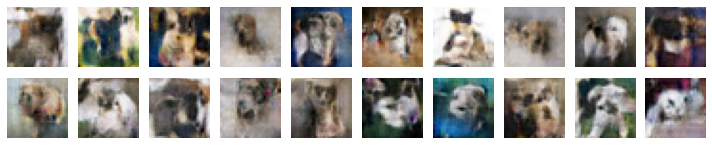

In [35]:
plot_output("20")